## Import Modules

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import joblib

## Load and Preprocess Data

In [10]:
# Load and preprocess
df = pd.read_csv("fleet_train.csv")
df["Measurement_timestamp"] = pd.to_datetime(df["Measurement_timestamp"], format="%d%b%y:%H:%M:%S")
df = df.sort_values(by=["Region", "truckid", "Measurement_timestamp"]).reset_index(drop=True)

# --- Load and preprocess test data ---
df_test = pd.read_csv("fleet_monitor_notscored_2.csv")  # <-- Update as needed
df_test["Measurement_timestamp"] = pd.to_datetime(df_test["Measurement_timestamp"], format="%d%b%y:%H:%M:%S")
df_test = df_test.sort_values(by=["Region", "truckid", "Measurement_timestamp"]).reset_index(drop=True)

# Sensor features
features = [
    "Vehicle_speed_sensor", "Vibration", "Engine_Load", "Engine_Coolant_Temp", "Intake_Manifold_Pressure",
    "Engine_RPM", "Speed_OBD", "Intake_Air_Temp", "Mass_Air_Flow_Rate", "Throttle_Pos_Manifold",
    "Voltage_Control_Module", "Ambient_air_temp", "Accel_Pedal_Pos_D", "Engine_Oil_Temp", "Speed_GPS",
    "Turbo_Boost_And_Vcm_Gauge", "Trip_Distance", "Litres_Per_100km_Inst", "Accel_Ssor_Total",
    "CO2_in_g_per_km_Inst", "Trip_Time_journey"
]

# Normalize
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
df_test[features] = scaler.fit_transform(df_test[features])
joblib.dump(scaler, "scaler.save")

['scaler.save']

## Apply SMOTE

In [47]:
# Sequence extraction
SEQUENCE_LENGTH = 10
X_seq, y_seq = [], []

for _, group in df.groupby(["Region", "truckid"]):
    if len(group) < SEQUENCE_LENGTH:
        continue
    X = group[features].values
    y = group["Maintenance_flag"].values
    for i in range(len(X) - SEQUENCE_LENGTH):
        X_seq.append(X[i:i+SEQUENCE_LENGTH])
        y_seq.append(y[i+SEQUENCE_LENGTH])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Flatten for SMOTE
X_seq_flat = X_seq.reshape(X_seq.shape[0], -1)

# Train-val split before applying SMOTE
X_train, X_val, y_train, y_val = train_test_split(X_seq_flat, y_seq, test_size=0.2, stratify=y_seq, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42, sampling_strategy=0.8, k_neighbors=2)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Reshape back to (batch, sequence, features)
X_train_resampled = X_train_resampled.reshape(-1, SEQUENCE_LENGTH, len(features))

# Convert to tensors and loaders
train_dataset = TensorDataset(torch.tensor(X_train_resampled, dtype=torch.float32),
                              torch.tensor(y_train_resampled, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val.reshape(-1, SEQUENCE_LENGTH, len(features)), dtype=torch.float32),
                            torch.tensor(y_val, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

In [12]:
# --- Test Dataset with extra metadata for output ---
class FleetTestDataset(Dataset):
    def __init__(self, df, features, seq_len):
        self.sequences = []
        self.labels = []
        self.meta = []  # to store Region, truckid, timestamp
        for _, group in df.groupby(["Region", "truckid"]):
            if len(group) < seq_len:
                continue
            X = group[features].values
            y = group["Maintenance_flag"].values
            ts = group["Measurement_timestamp"].values
            for i in range(len(X) - seq_len):
                self.sequences.append(X[i:i+seq_len])
                self.labels.append(y[i+seq_len])
                self.meta.append({
                    "Region": group["Region"].iloc[i+seq_len],
                    "truckid": group["truckid"].iloc[i+seq_len],
                    "Measurement_timestamp": str(group["Measurement_timestamp"].iloc[i+seq_len])  # convert to string
                })


    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        x = torch.tensor(self.sequences[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)
        return x, y, self.meta[idx]
    
def custom_collate_fn(batch):
    xs, ys, metas = zip(*batch)
    xs = torch.stack(xs)
    ys = torch.stack(ys)
    return xs, ys, metas  # metas stays as a list of dicts


test_dataset = FleetTestDataset(df_test, features, SEQUENCE_LENGTH)
test_loader = DataLoader(test_dataset, batch_size=8, collate_fn=custom_collate_fn)

## LSTM Model

In [13]:
# Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_sizes=[200, 100, 50], dropout=0.2):
        super().__init__()
        self.lstm_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
 
        self.lstm_layers.append(nn.LSTM(input_size=input_size, hidden_size=hidden_sizes[0], batch_first=True, bidirectional=True))
        self.dropout_layers.append(nn.Dropout(dropout))
 
        for i in range(1, len(hidden_sizes)):
            self.lstm_layers.append(
                nn.LSTM(input_size=hidden_sizes[i-1] * 2, hidden_size=hidden_sizes[i], batch_first=True, bidirectional=True)
            )
            self.dropout_layers.append(nn.Dropout(dropout))
 
        self.fc = nn.Linear(hidden_sizes[-1] * 2, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        for lstm, dropout in zip(self.lstm_layers, self.dropout_layers):
            x, _ = lstm(x)
            x = dropout(x)
 
        last_out = x[:, -1, :]
        out = self.fc(last_out)
        return self.sigmoid(out).squeeze()
 

## Training

In [48]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_size=len(features), hidden_sizes=[256, 128], dropout=0.2).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Early stopping
best_loss = np.inf
patience = 20
trigger_times = 0

In [49]:
# model.load_state_dict(torch.load("best_model_08-18.pt", map_location=device))

EPOCHS = 500
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for X, y in loop:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        loop.set_postfix(train_loss=loss.item())

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += criterion(pred, y).item()

    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}: Train Loss = {train_loss/len(train_loader):.6f}, Val Loss = {val_loss:.6f}")

    if val_loss < best_loss:
        best_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), "best_model_08-18.pt")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/500: 100%|██████████| 995/995 [00:03<00:00, 255.88it/s, train_loss=0.693]


Epoch 1: Train Loss = 0.679017, Val Loss = 0.569071


Epoch 2/500: 100%|██████████| 995/995 [00:03<00:00, 275.97it/s, train_loss=0.569]


Epoch 2: Train Loss = 0.588612, Val Loss = 0.523293


Epoch 3/500: 100%|██████████| 995/995 [00:03<00:00, 275.39it/s, train_loss=0.601]


Epoch 3: Train Loss = 0.531123, Val Loss = 0.511872


Epoch 4/500: 100%|██████████| 995/995 [00:03<00:00, 261.34it/s, train_loss=0.469]


Epoch 4: Train Loss = 0.516119, Val Loss = 0.491408


Epoch 5/500: 100%|██████████| 995/995 [00:03<00:00, 277.29it/s, train_loss=0.571]


Epoch 5: Train Loss = 0.503074, Val Loss = 0.470099


Epoch 6/500: 100%|██████████| 995/995 [00:03<00:00, 277.06it/s, train_loss=0.371]


Epoch 6: Train Loss = 0.487622, Val Loss = 0.439505


Epoch 7/500: 100%|██████████| 995/995 [00:03<00:00, 278.37it/s, train_loss=0.292] 


Epoch 7: Train Loss = 0.470342, Val Loss = 0.435576


Epoch 8/500: 100%|██████████| 995/995 [00:03<00:00, 277.37it/s, train_loss=0.323] 


Epoch 8: Train Loss = 0.452543, Val Loss = 0.432675


Epoch 9/500: 100%|██████████| 995/995 [00:03<00:00, 276.83it/s, train_loss=0.472] 


Epoch 9: Train Loss = 0.438836, Val Loss = 0.394831


Epoch 10/500: 100%|██████████| 995/995 [00:03<00:00, 278.06it/s, train_loss=0.217] 


Epoch 10: Train Loss = 0.433148, Val Loss = 0.405571


Epoch 11/500: 100%|██████████| 995/995 [00:03<00:00, 276.40it/s, train_loss=0.175] 


Epoch 11: Train Loss = 0.424492, Val Loss = 0.420306


Epoch 12/500: 100%|██████████| 995/995 [00:03<00:00, 278.05it/s, train_loss=0.513] 


Epoch 12: Train Loss = 0.421554, Val Loss = 0.424678


Epoch 13/500: 100%|██████████| 995/995 [00:03<00:00, 276.29it/s, train_loss=0.118] 


Epoch 13: Train Loss = 0.413799, Val Loss = 0.444135


Epoch 14/500: 100%|██████████| 995/995 [00:03<00:00, 275.85it/s, train_loss=0.482] 


Epoch 14: Train Loss = 0.410165, Val Loss = 0.399297


Epoch 15/500: 100%|██████████| 995/995 [00:03<00:00, 276.29it/s, train_loss=0.315] 


Epoch 15: Train Loss = 0.406172, Val Loss = 0.404070


Epoch 16/500: 100%|██████████| 995/995 [00:03<00:00, 276.93it/s, train_loss=0.651] 


Epoch 16: Train Loss = 0.404054, Val Loss = 0.390413


Epoch 17/500: 100%|██████████| 995/995 [00:03<00:00, 276.82it/s, train_loss=0.109] 


Epoch 17: Train Loss = 0.398666, Val Loss = 0.397862


Epoch 18/500: 100%|██████████| 995/995 [00:03<00:00, 276.20it/s, train_loss=0.748] 


Epoch 18: Train Loss = 0.397484, Val Loss = 0.391502


Epoch 19/500: 100%|██████████| 995/995 [00:03<00:00, 277.33it/s, train_loss=0.0583]


Epoch 19: Train Loss = 0.393556, Val Loss = 0.390268


Epoch 20/500: 100%|██████████| 995/995 [00:03<00:00, 275.98it/s, train_loss=0.167] 


Epoch 20: Train Loss = 0.388702, Val Loss = 0.346527


Epoch 21/500: 100%|██████████| 995/995 [00:03<00:00, 277.05it/s, train_loss=0.499]  


Epoch 21: Train Loss = 0.384055, Val Loss = 0.364095


Epoch 22/500: 100%|██████████| 995/995 [00:03<00:00, 276.40it/s, train_loss=0.279] 


Epoch 22: Train Loss = 0.380114, Val Loss = 0.370365


Epoch 23/500: 100%|██████████| 995/995 [00:03<00:00, 275.97it/s, train_loss=0.298] 


Epoch 23: Train Loss = 0.377780, Val Loss = 0.353262


Epoch 24/500: 100%|██████████| 995/995 [00:03<00:00, 276.60it/s, train_loss=0.196] 


Epoch 24: Train Loss = 0.374390, Val Loss = 0.364277


Epoch 25/500: 100%|██████████| 995/995 [00:03<00:00, 276.42it/s, train_loss=0.334] 


Epoch 25: Train Loss = 0.372744, Val Loss = 0.362195


Epoch 26/500: 100%|██████████| 995/995 [00:03<00:00, 276.26it/s, train_loss=0.137] 


Epoch 26: Train Loss = 0.369551, Val Loss = 0.337004


Epoch 27/500: 100%|██████████| 995/995 [00:03<00:00, 277.50it/s, train_loss=0.636] 


Epoch 27: Train Loss = 0.368704, Val Loss = 0.350567


Epoch 28/500: 100%|██████████| 995/995 [00:03<00:00, 276.23it/s, train_loss=0.507] 


Epoch 28: Train Loss = 0.364505, Val Loss = 0.359294


Epoch 29/500: 100%|██████████| 995/995 [00:03<00:00, 275.96it/s, train_loss=0.065]  


Epoch 29: Train Loss = 0.364066, Val Loss = 0.348356


Epoch 30/500: 100%|██████████| 995/995 [00:03<00:00, 277.06it/s, train_loss=0.207] 


Epoch 30: Train Loss = 0.363167, Val Loss = 0.351686


Epoch 31/500: 100%|██████████| 995/995 [00:03<00:00, 276.29it/s, train_loss=0.743] 


Epoch 31: Train Loss = 0.361818, Val Loss = 0.339616


Epoch 32/500: 100%|██████████| 995/995 [00:03<00:00, 275.39it/s, train_loss=0.11]  


Epoch 32: Train Loss = 0.359649, Val Loss = 0.341629


Epoch 33/500: 100%|██████████| 995/995 [00:04<00:00, 245.46it/s, train_loss=0.146]  


Epoch 33: Train Loss = 0.358389, Val Loss = 0.352731


Epoch 34/500: 100%|██████████| 995/995 [00:03<00:00, 274.84it/s, train_loss=0.204] 


Epoch 34: Train Loss = 0.358336, Val Loss = 0.327168


Epoch 35/500: 100%|██████████| 995/995 [00:03<00:00, 277.64it/s, train_loss=0.708] 


Epoch 35: Train Loss = 0.356465, Val Loss = 0.326908


Epoch 36/500: 100%|██████████| 995/995 [00:03<00:00, 277.76it/s, train_loss=0.417] 


Epoch 36: Train Loss = 0.356451, Val Loss = 0.334484


Epoch 37/500: 100%|██████████| 995/995 [00:03<00:00, 275.91it/s, train_loss=0.057] 


Epoch 37: Train Loss = 0.357124, Val Loss = 0.340451


Epoch 38/500: 100%|██████████| 995/995 [00:03<00:00, 276.42it/s, train_loss=0.049] 


Epoch 38: Train Loss = 0.354214, Val Loss = 0.352769


Epoch 39/500: 100%|██████████| 995/995 [00:03<00:00, 277.25it/s, train_loss=0.371] 


Epoch 39: Train Loss = 0.353949, Val Loss = 0.335443


Epoch 40/500: 100%|██████████| 995/995 [00:03<00:00, 275.36it/s, train_loss=0.268] 


Epoch 40: Train Loss = 0.352632, Val Loss = 0.335601


Epoch 41/500: 100%|██████████| 995/995 [00:03<00:00, 277.71it/s, train_loss=0.226]  


Epoch 41: Train Loss = 0.351774, Val Loss = 0.326133


Epoch 42/500: 100%|██████████| 995/995 [00:03<00:00, 277.67it/s, train_loss=1.12]  


Epoch 42: Train Loss = 0.352389, Val Loss = 0.333550


Epoch 43/500: 100%|██████████| 995/995 [00:03<00:00, 275.90it/s, train_loss=0.215] 


Epoch 43: Train Loss = 0.350882, Val Loss = 0.338174


Epoch 44/500: 100%|██████████| 995/995 [00:03<00:00, 275.74it/s, train_loss=0.374] 


Epoch 44: Train Loss = 0.350348, Val Loss = 0.322662


Epoch 45/500: 100%|██████████| 995/995 [00:03<00:00, 277.74it/s, train_loss=0.0613]


Epoch 45: Train Loss = 0.351553, Val Loss = 0.347096


Epoch 46/500: 100%|██████████| 995/995 [00:03<00:00, 276.16it/s, train_loss=0.583] 


Epoch 46: Train Loss = 0.350411, Val Loss = 0.354446


Epoch 47/500: 100%|██████████| 995/995 [00:03<00:00, 277.28it/s, train_loss=0.22]  


Epoch 47: Train Loss = 0.348558, Val Loss = 0.330496


Epoch 48/500: 100%|██████████| 995/995 [00:03<00:00, 277.28it/s, train_loss=0.124]  


Epoch 48: Train Loss = 0.348356, Val Loss = 0.324769


Epoch 49/500: 100%|██████████| 995/995 [00:03<00:00, 277.39it/s, train_loss=0.208] 


Epoch 49: Train Loss = 0.346641, Val Loss = 0.340140


Epoch 50/500: 100%|██████████| 995/995 [00:03<00:00, 276.59it/s, train_loss=0.274]  


Epoch 50: Train Loss = 0.347375, Val Loss = 0.337556


Epoch 51/500: 100%|██████████| 995/995 [00:03<00:00, 276.48it/s, train_loss=0.881] 


Epoch 51: Train Loss = 0.347559, Val Loss = 0.344693


Epoch 52/500: 100%|██████████| 995/995 [00:03<00:00, 276.01it/s, train_loss=0.19]  


Epoch 52: Train Loss = 0.347236, Val Loss = 0.332234


Epoch 53/500: 100%|██████████| 995/995 [00:03<00:00, 276.31it/s, train_loss=0.725]  


Epoch 53: Train Loss = 0.345089, Val Loss = 0.332522


Epoch 54/500: 100%|██████████| 995/995 [00:03<00:00, 275.75it/s, train_loss=0.173]  


Epoch 54: Train Loss = 0.345624, Val Loss = 0.333391


Epoch 55/500: 100%|██████████| 995/995 [00:03<00:00, 277.46it/s, train_loss=0.383] 


Epoch 55: Train Loss = 0.343956, Val Loss = 0.337337


Epoch 56/500: 100%|██████████| 995/995 [00:03<00:00, 276.93it/s, train_loss=0.588] 


Epoch 56: Train Loss = 0.342966, Val Loss = 0.329460


Epoch 57/500: 100%|██████████| 995/995 [00:03<00:00, 275.59it/s, train_loss=0.511] 


Epoch 57: Train Loss = 0.341669, Val Loss = 0.330678


Epoch 58/500: 100%|██████████| 995/995 [00:03<00:00, 276.42it/s, train_loss=0.113] 


Epoch 58: Train Loss = 0.340137, Val Loss = 0.328500


Epoch 59/500: 100%|██████████| 995/995 [00:03<00:00, 276.82it/s, train_loss=0.102]  


Epoch 59: Train Loss = 0.338858, Val Loss = 0.328590


Epoch 60/500: 100%|██████████| 995/995 [00:03<00:00, 275.65it/s, train_loss=0.648] 


Epoch 60: Train Loss = 0.336098, Val Loss = 0.318665


Epoch 61/500: 100%|██████████| 995/995 [00:03<00:00, 277.38it/s, train_loss=0.356]  


Epoch 61: Train Loss = 0.334946, Val Loss = 0.325493


Epoch 62/500: 100%|██████████| 995/995 [00:03<00:00, 276.98it/s, train_loss=0.289] 


Epoch 62: Train Loss = 0.331453, Val Loss = 0.306891


Epoch 63/500: 100%|██████████| 995/995 [00:03<00:00, 277.02it/s, train_loss=0.138]   


Epoch 63: Train Loss = 0.328653, Val Loss = 0.333634


Epoch 64/500: 100%|██████████| 995/995 [00:03<00:00, 276.89it/s, train_loss=0.205] 


Epoch 64: Train Loss = 0.323838, Val Loss = 0.296548


Epoch 65/500: 100%|██████████| 995/995 [00:03<00:00, 278.18it/s, train_loss=0.211] 


Epoch 65: Train Loss = 0.315060, Val Loss = 0.313494


Epoch 66/500: 100%|██████████| 995/995 [00:03<00:00, 275.74it/s, train_loss=0.487]  


Epoch 66: Train Loss = 0.308292, Val Loss = 0.310963


Epoch 67/500: 100%|██████████| 995/995 [00:03<00:00, 276.27it/s, train_loss=0.613] 


Epoch 67: Train Loss = 0.300945, Val Loss = 0.297547


Epoch 68/500: 100%|██████████| 995/995 [00:03<00:00, 276.81it/s, train_loss=0.72]   


Epoch 68: Train Loss = 0.296990, Val Loss = 0.289676


Epoch 69/500: 100%|██████████| 995/995 [00:03<00:00, 276.35it/s, train_loss=0.0509] 


Epoch 69: Train Loss = 0.294485, Val Loss = 0.282355


Epoch 70/500: 100%|██████████| 995/995 [00:03<00:00, 277.49it/s, train_loss=0.123]  


Epoch 70: Train Loss = 0.290932, Val Loss = 0.286589


Epoch 71/500: 100%|██████████| 995/995 [00:04<00:00, 247.05it/s, train_loss=0.153]  


Epoch 71: Train Loss = 0.293117, Val Loss = 0.286008


Epoch 72/500: 100%|██████████| 995/995 [00:03<00:00, 276.12it/s, train_loss=0.349]  


Epoch 72: Train Loss = 0.290325, Val Loss = 0.290759


Epoch 73/500: 100%|██████████| 995/995 [00:03<00:00, 276.77it/s, train_loss=0.154] 


Epoch 73: Train Loss = 0.288781, Val Loss = 0.300742


Epoch 74/500: 100%|██████████| 995/995 [00:03<00:00, 276.17it/s, train_loss=0.734]  


Epoch 74: Train Loss = 0.287048, Val Loss = 0.280233


Epoch 75/500: 100%|██████████| 995/995 [00:03<00:00, 277.70it/s, train_loss=0.386]  


Epoch 75: Train Loss = 0.288741, Val Loss = 0.285311


Epoch 76/500: 100%|██████████| 995/995 [00:03<00:00, 278.46it/s, train_loss=0.389]   


Epoch 76: Train Loss = 0.287781, Val Loss = 0.277798


Epoch 77/500: 100%|██████████| 995/995 [00:03<00:00, 276.09it/s, train_loss=0.32]   


Epoch 77: Train Loss = 0.284553, Val Loss = 0.293092


Epoch 78/500: 100%|██████████| 995/995 [00:03<00:00, 276.51it/s, train_loss=0.442]  


Epoch 78: Train Loss = 0.285440, Val Loss = 0.284750


Epoch 79/500: 100%|██████████| 995/995 [00:03<00:00, 276.15it/s, train_loss=0.0439] 


Epoch 79: Train Loss = 0.285760, Val Loss = 0.282688


Epoch 80/500: 100%|██████████| 995/995 [00:03<00:00, 276.39it/s, train_loss=0.331] 


Epoch 80: Train Loss = 0.284758, Val Loss = 0.282428


Epoch 81/500: 100%|██████████| 995/995 [00:03<00:00, 276.32it/s, train_loss=0.046]   


Epoch 81: Train Loss = 0.285347, Val Loss = 0.282406


Epoch 82/500: 100%|██████████| 995/995 [00:03<00:00, 276.94it/s, train_loss=0.373] 


Epoch 82: Train Loss = 0.282184, Val Loss = 0.288647


Epoch 83/500: 100%|██████████| 995/995 [00:03<00:00, 275.68it/s, train_loss=0.315] 


Epoch 83: Train Loss = 0.282565, Val Loss = 0.294521


Epoch 84/500: 100%|██████████| 995/995 [00:03<00:00, 276.29it/s, train_loss=0.347]   


Epoch 84: Train Loss = 0.283514, Val Loss = 0.284504


Epoch 85/500: 100%|██████████| 995/995 [00:03<00:00, 276.86it/s, train_loss=0.656] 


Epoch 85: Train Loss = 0.284843, Val Loss = 0.284815


Epoch 86/500: 100%|██████████| 995/995 [00:03<00:00, 275.49it/s, train_loss=0.156]  


Epoch 86: Train Loss = 0.282345, Val Loss = 0.286468


Epoch 87/500: 100%|██████████| 995/995 [00:03<00:00, 276.52it/s, train_loss=0.169]  


Epoch 87: Train Loss = 0.281670, Val Loss = 0.282145


Epoch 88/500: 100%|██████████| 995/995 [00:03<00:00, 277.30it/s, train_loss=0.448]  


Epoch 88: Train Loss = 0.281379, Val Loss = 0.283812


Epoch 89/500: 100%|██████████| 995/995 [00:03<00:00, 276.63it/s, train_loss=0.446] 


Epoch 89: Train Loss = 0.281279, Val Loss = 0.285965


Epoch 90/500: 100%|██████████| 995/995 [00:03<00:00, 276.55it/s, train_loss=0.416] 


Epoch 90: Train Loss = 0.283344, Val Loss = 0.287134


Epoch 91/500: 100%|██████████| 995/995 [00:03<00:00, 276.47it/s, train_loss=0.132] 


Epoch 91: Train Loss = 0.280624, Val Loss = 0.280577


Epoch 92/500: 100%|██████████| 995/995 [00:03<00:00, 276.11it/s, train_loss=0.817]  


Epoch 92: Train Loss = 0.281592, Val Loss = 0.291180


Epoch 93/500: 100%|██████████| 995/995 [00:03<00:00, 277.50it/s, train_loss=0.778] 


Epoch 93: Train Loss = 0.280652, Val Loss = 0.278506


Epoch 94/500: 100%|██████████| 995/995 [00:03<00:00, 274.87it/s, train_loss=0.419]  


Epoch 94: Train Loss = 0.281690, Val Loss = 0.281484


Epoch 95/500: 100%|██████████| 995/995 [00:03<00:00, 275.94it/s, train_loss=0.443]  


Epoch 95: Train Loss = 0.279101, Val Loss = 0.284266


Epoch 96/500: 100%|██████████| 995/995 [00:03<00:00, 276.88it/s, train_loss=0.464]  


Epoch 96: Train Loss = 0.281049, Val Loss = 0.286863
Early stopping triggered.


## Testing

   Region       truckid Measurement_timestamp  Maintenance_flag  \
0       1  Truck_0021X1   2016-02-22 16:02:52                 0   
1       1  Truck_0021X1   2016-02-22 16:02:54                 0   
2       1  Truck_0021X1   2016-02-22 16:03:08                 0   
3       1  Truck_0021X1   2016-02-22 16:03:09                 0   
4       1  Truck_0021X1   2016-02-22 16:03:12                 0   

   Prediction_Prob  Prediction_Label  
0         0.002819                 0  
1         0.004143                 0  
2         0.007117                 0  
3         0.008088                 0  
4         0.007732                 0  

Confusion Matrix:
[[1007  148]
 [  15  264]]

Classification Metrics:
  Accuracy:  0.8863
  Precision: 0.6408
  Recall:    0.9462
  F1 Score:  0.7641
  ROC AUC:   0.9396


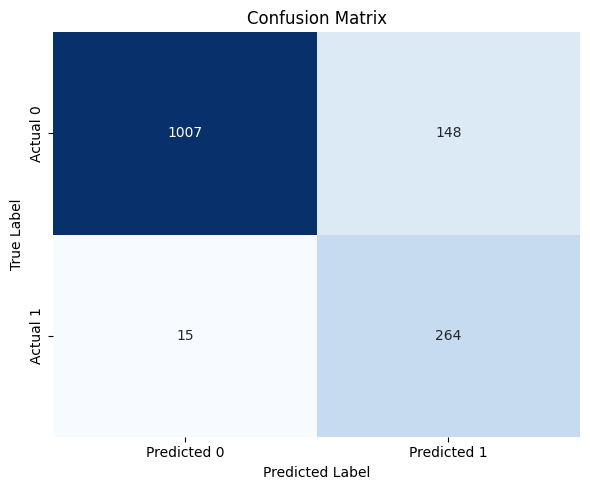

In [50]:
# --- Inference and DataFrame creation ---
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

model.load_state_dict(torch.load("best_model_08-18.pt", map_location=device))
model.eval()

threshold = 0.5

results = []
all_true = []
all_pred = []
all_probs = []

with torch.no_grad():
    for X_batch, y_batch, meta_batch in test_loader:
        X_batch = X_batch.to(device)
        probs = model(X_batch)
        preds = (probs >= 0.5).int()

        for prob, pred, y_true, meta in zip(probs, preds, y_batch.numpy(), meta_batch):
            results.append({
                "Region": meta["Region"],
                "truckid": meta["truckid"],
                "Measurement_timestamp": meta["Measurement_timestamp"],
                "Maintenance_flag": int(y_true),
                "Prediction_Prob": float(prob),
                "Prediction_Label": int(pred)
            })
            all_true.append(int(y_true))
            all_pred.append(int(pred))
            all_probs.append(float(prob))

# --- Create result DataFrame ---
result_df = pd.DataFrame(results)
print(result_df.head())
result_df.to_csv("lstm_test_predictions.csv", index=False)

# --- Compute Metrics ---
conf_matrix = confusion_matrix(all_true, all_pred)
accuracy = accuracy_score(all_true, all_pred)
precision = precision_score(all_true, all_pred, zero_division=0)
recall = recall_score(all_true, all_pred, zero_division=0)
f1 = f1_score(all_true, all_pred, zero_division=0)
try:
    roc_auc = roc_auc_score(all_true, all_probs)
except:
    roc_auc = None

# --- Display Results ---
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Metrics:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")
if roc_auc is not None:
    print(f"  ROC AUC:   {roc_auc:.4f}")
else:
    print("  ROC AUC:   Not computable (only one class in y_true)")

import seaborn as sns
import matplotlib.pyplot as plt

# --- Visualize Confusion Matrix ---
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()

# Save the figure
plt.savefig("lstm_confusion_matrix.png")
plt.show()


## Agentic AI

In [17]:
from langgraph.graph import StateGraph, END
from typing import TypedDict
import pandas as pd
import torch
import joblib

# -----------------------------
# Constants & model loading
# -----------------------------
features = [
    "Vehicle_speed_sensor", "Vibration", "Engine_Load", "Engine_Coolant_Temp",
    "Intake_Manifold_Pressure", "Engine_RPM", "Speed_OBD", "Intake_Air_Temp",
    "Mass_Air_Flow_Rate", "Throttle_Pos_Manifold", "Voltage_Control_Module",
    "Ambient_air_temp", "Accel_Pedal_Pos_D", "Engine_Oil_Temp", "Speed_GPS",
    "Turbo_Boost_And_Vcm_Gauge", "Trip_Distance", "Litres_Per_100km_Inst",
    "Accel_Ssor_Total", "CO2_in_g_per_km_Inst", "Trip_Time_journey"
]
SEQUENCE_LENGTH = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMModel(input_size=len(features), hidden_sizes=[200, 100, 50], dropout=0.3).to(device)
model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.eval()

scaler = joblib.load("scaler.save")

# -----------------------------
# State definition
# -----------------------------
class MaintenanceState(TypedDict):
    fleetid: str
    truckid: str
    region: str
    new_reading: dict
    X_seq: torch.Tensor
    prob: float
    maintenance_needed: bool

# -----------------------------
# Tool 1: Get new reading
# -----------------------------
def get_new_sensor_reading(state: MaintenanceState):
    """
    Simulate getting new sensor readings from the truck.
    """
    state["new_reading"] = {
        "Measurement_timestamp": "22FEB16:17:55:52",
        "Vehicle_speed_sensor": 26,
        "Vibration": 249.689536,
        "Engine_Load": 31.764706,
        "Engine_Coolant_Temp": 87,
        "Intake_Manifold_Pressure": 118,
        "Engine_RPM": 1129,
        "Speed_OBD": 26,
        "Intake_Air_Temp": 17,
        "Mass_Air_Flow_Rate": 19.02,
        "Throttle_Pos_Manifold": 45.09804,
        "Voltage_Control_Module": 14.28,
        "Ambient_air_temp": 6,
        "Accel_Pedal_Pos_D": 14.901961,
        "Engine_Oil_Temp": 83,
        "Speed_GPS": 27.578842,
        "Turbo_Boost_And_Vcm_Gauge": 8.550445794,
        "Trip_Distance": 49.66853177,
        "Litres_Per_100km_Inst": 21.3,
        "Accel_Ssor_Total": 156,
        "CO2_in_g_per_km_Inst": 3.045792,
        "Trip_Time_journey": 289.88788,
        "fleetid": state["fleetid"],
        "truckid": state["truckid"],
        "Region": state["region"]
    }
    return state

# -----------------------------
# Tool 2: Prepare data
# -----------------------------
def prepare_data(state: MaintenanceState):
    """
    Load past data, append the new reading, scale features, and prepare sequence.
    """
    df = pd.read_csv("fleet_monitor_notscored_2.csv")
    df["Measurement_timestamp"] = pd.to_datetime(df["Measurement_timestamp"], format="%d%b%y:%H:%M:%S")

    # Filter historical readings
    df = df[
        (df["fleetid"] == state["fleetid"]) &
        (df["Region"] == state["region"]) &
        (df["truckid"] == state["truckid"])
    ]

    # Append new reading
    new_df = pd.DataFrame([state["new_reading"]])
    new_df["Measurement_timestamp"] = pd.to_datetime(new_df["Measurement_timestamp"], format="%d%b%y:%H:%M:%S")
    df = pd.concat([df, new_df], ignore_index=True)

    # Sort by timestamp
    df = df.sort_values(by="Measurement_timestamp")

    # Check sequence length
    if len(df) < SEQUENCE_LENGTH:
        raise ValueError(f"Not enough data for truck {state['truckid']} in {state['region']}.")

    # Scale features
    df[features] = scaler.transform(df[features])

    # Prepare sequence for model
    seq_data = df[features].tail(SEQUENCE_LENGTH).values
    state["X_seq"] = torch.tensor(seq_data, dtype=torch.float32).unsqueeze(0).to(device)

    return state

# -----------------------------
# Tool 3: Run prediction
# -----------------------------
def run_prediction(state: MaintenanceState):
    with torch.no_grad():
        prob = model(state["X_seq"]).item()
    state["prob"] = prob
    state["maintenance_needed"] = prob >= 0.5
    return state

# -----------------------------
# Tool 4: Store new reading
# -----------------------------
def store_new_reading(state: MaintenanceState):
    print(f"✅ New reading for truck {state['truckid']} stored in database (simulated).")
    return state



# -----------------------------
# Build LangGraph
# -----------------------------
graph = StateGraph(MaintenanceState)

graph.add_node("get_new_sensor_reading", get_new_sensor_reading)
graph.add_node("prepare_data", prepare_data)
graph.add_node("run_prediction", run_prediction)
graph.add_node("store_new_reading", store_new_reading)

# Define flow
graph.set_entry_point("get_new_sensor_reading")
graph.add_edge("get_new_sensor_reading", "prepare_data")
graph.add_edge("prepare_data", "run_prediction")
graph.add_edge("run_prediction", "store_new_reading")
graph.add_edge("store_new_reading", END)

agent = graph.compile()




RuntimeError: Error(s) in loading state_dict for LSTMModel:
	Missing key(s) in state_dict: "lstm_layers.0.weight_ih_l0_reverse", "lstm_layers.0.weight_hh_l0_reverse", "lstm_layers.0.bias_ih_l0_reverse", "lstm_layers.0.bias_hh_l0_reverse", "lstm_layers.1.weight_ih_l0_reverse", "lstm_layers.1.weight_hh_l0_reverse", "lstm_layers.1.bias_ih_l0_reverse", "lstm_layers.1.bias_hh_l0_reverse", "lstm_layers.2.weight_ih_l0_reverse", "lstm_layers.2.weight_hh_l0_reverse", "lstm_layers.2.bias_ih_l0_reverse", "lstm_layers.2.bias_hh_l0_reverse". 
	size mismatch for lstm_layers.1.weight_ih_l0: copying a param with shape torch.Size([400, 200]) from checkpoint, the shape in current model is torch.Size([400, 400]).
	size mismatch for lstm_layers.2.weight_ih_l0: copying a param with shape torch.Size([200, 100]) from checkpoint, the shape in current model is torch.Size([200, 200]).
	size mismatch for fc.weight: copying a param with shape torch.Size([1, 50]) from checkpoint, the shape in current model is torch.Size([1, 100]).

In [ ]:
# -----------------------------
# Example usage
# -----------------------------
result = agent.invoke({
    "fleetid": "Fleet_00513F1",
    "truckid": "Truck_0051X1",
    "region": 1
})

print(f"Truck {result['truckid']} in region {result['region']}: "
      f"{'Needs Maintenance' if result['maintenance_needed'] else 'OK'} "
      f"(prob={result['prob']:.2f})")

✅ New reading for truck Truck_0051X1 stored in database (simulated).
Truck Truck_0051X1 in region 1: Needs Maintenance (prob=0.82)
